# EDA & Modeling Workbook

In [89]:
%config InlineBackend.figure_formats = ['retina']

import pickle
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
import math
from sklearn.metrics import mean_squared_error

Load data.

In [2]:
pickleFile = open('mergedDf4.pickle', 'rb')
df_movies= pickle.load(pickleFile)
pickleFile.close() 

In [3]:
df_movies.shape

(870, 60)

In [4]:
df_movies_r = df_movies[['gross_us_canada', 'running_time', 'budget', 'number_of_cast_members',
       'qty_writers', 'qty_art_department', 'qty_sound_department',
       'qty_special_effects', 'qty_visual_effects',
       'qty_camera_and_electrical_department', 'qty_casting_department',
       'qty_editorial_department', 'qty_music_department']]

In [5]:
df_movies_r.shape

(870, 13)

In [6]:
pickleFile = open('df_movies_r.pickle', 'wb')
pickle.dump(df_movies_r,pickleFile,pickle.HIGHEST_PROTOCOL)
pickleFile.close()

In [7]:
pickleFile = open('df_movies_r.pickle', 'rb')
df_movies= pickle.load(pickleFile)
pickleFile.close() 

In [8]:
df_movies.shape

(870, 13)

## Simple EDA

Look at possible outliers

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` spe

<AxesSubplot:xlabel='qty_music_department'>

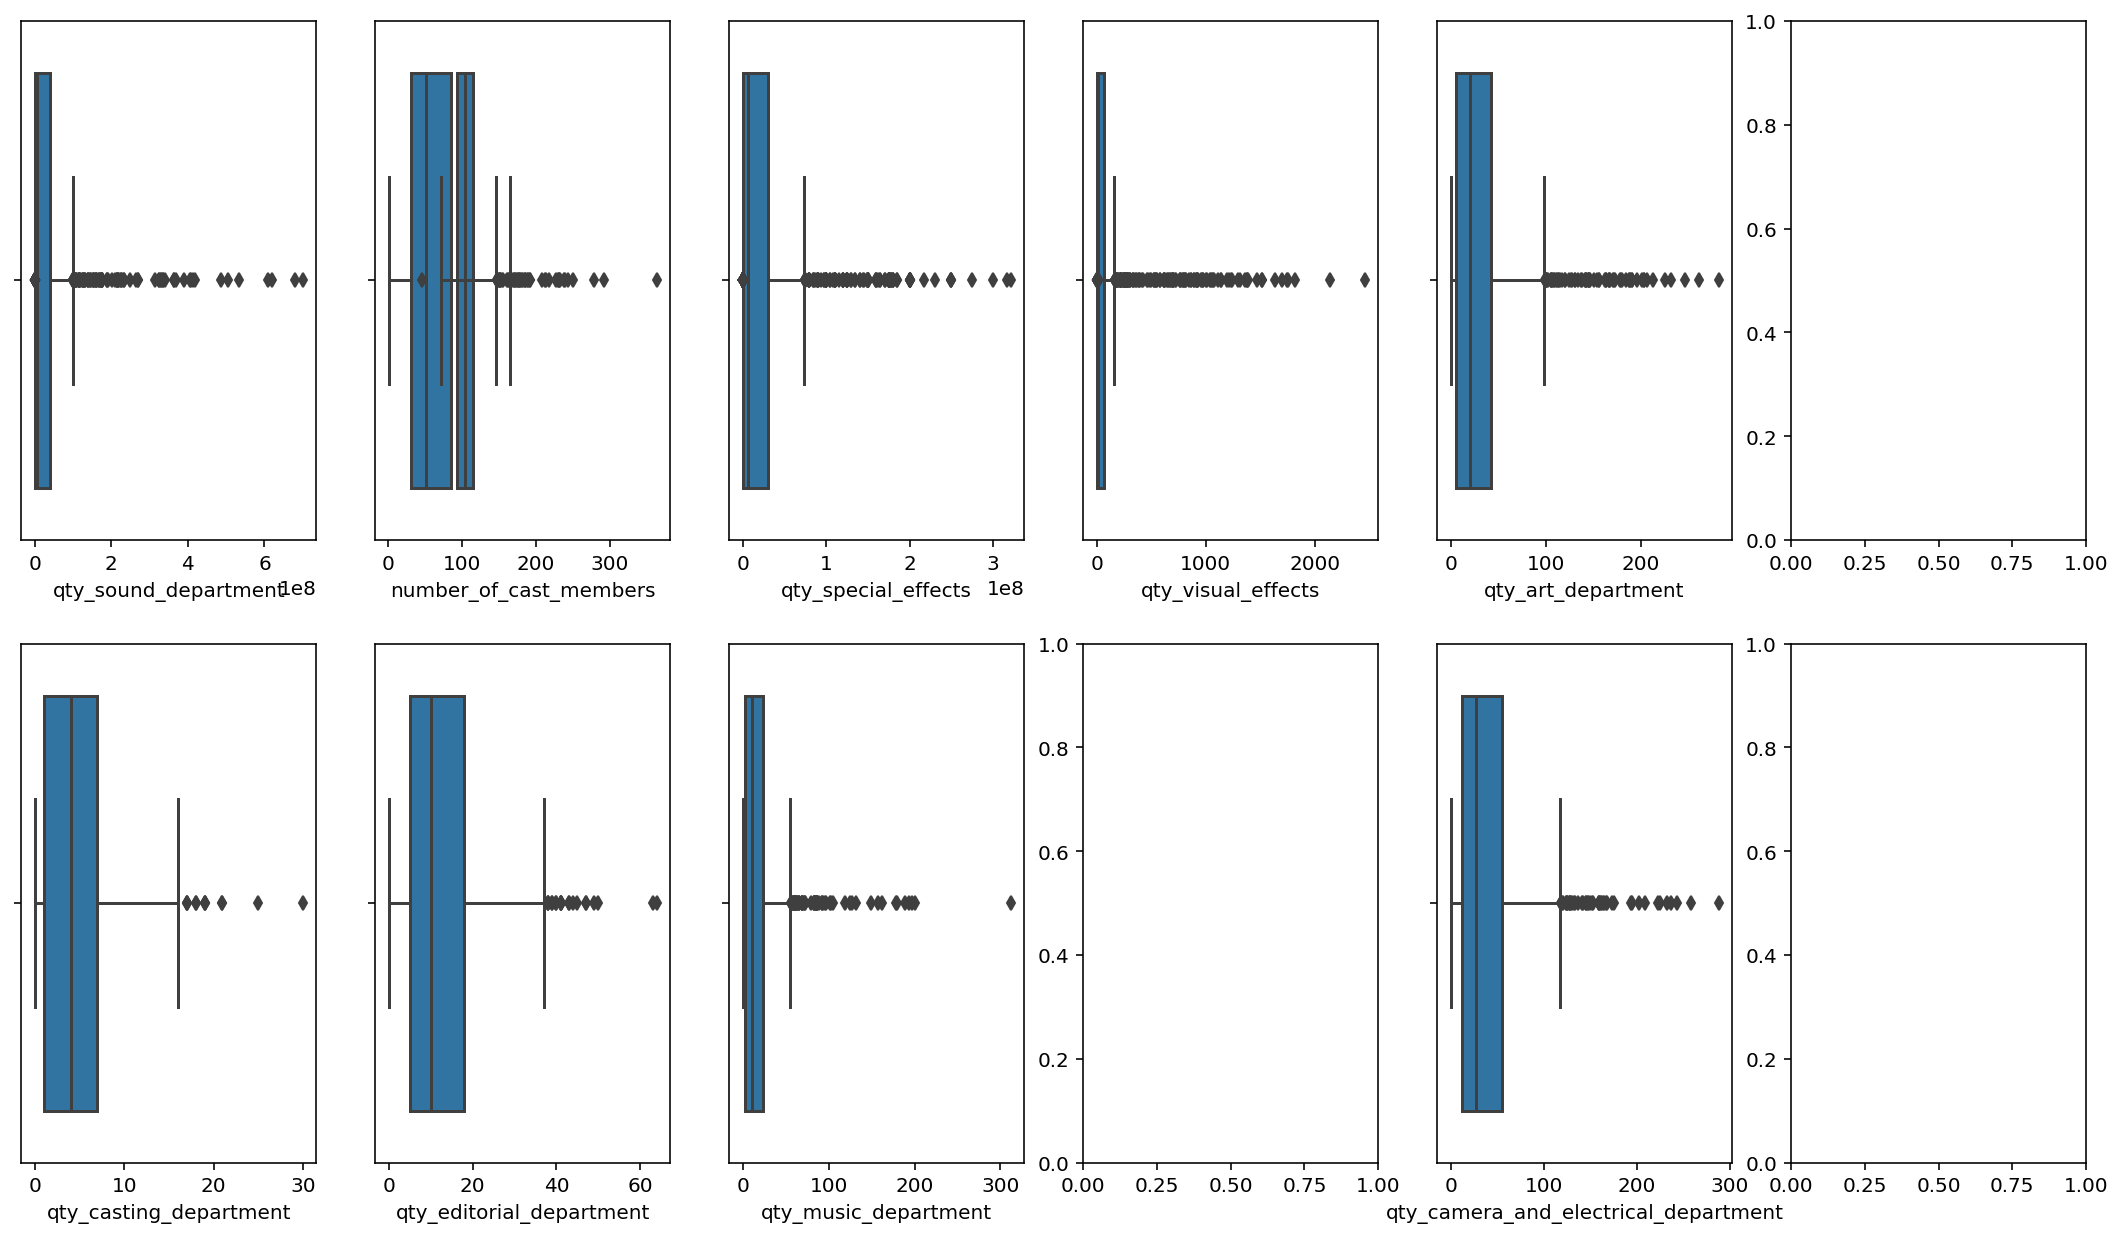

In [57]:
f, axes = plt.subplots(2, 6)
f.set_size_inches(18.5, 10.5)
sns.boxplot(df_movies['gross_us_canada'], orient='v', ax=axes[0, 0])
sns.boxplot(df_movies['running_time'], orient='v', ax=axes[0, 1])
sns.boxplot(df_movies['budget'], orient='v', ax=axes[0, 2])
sns.boxplot(df_movies['qty_writers'], orient='v', ax=axes[0, 3])
sns.boxplot(df_movies['qty_art_department'], orient='v', ax=axes[0, 4])
sns.boxplot(df_movies['qty_sound_department'], orient='v', ax=axes[0, 0])
sns.boxplot(df_movies['number_of_cast_members'], orient='v', ax=axes[0, 1])
sns.boxplot(df_movies['qty_special_effects'], orient='v', ax=axes[0, 2])
sns.boxplot(df_movies['qty_visual_effects'], orient='v', ax=axes[0, 3])
sns.boxplot(df_movies['qty_camera_and_electrical_department'], orient='v', ax=axes[1, 4])
sns.boxplot(df_movies['qty_casting_department'], orient='v', ax=axes[1, 0])
sns.boxplot(df_movies['qty_editorial_department'], orient='v', ax=axes[1, 1])
sns.boxplot(df_movies['qty_music_department'], orient='v', ax=axes[1, 2])

Visualize distributions of each feature and potential linearities between each feature and the target, as well as amongst the features.

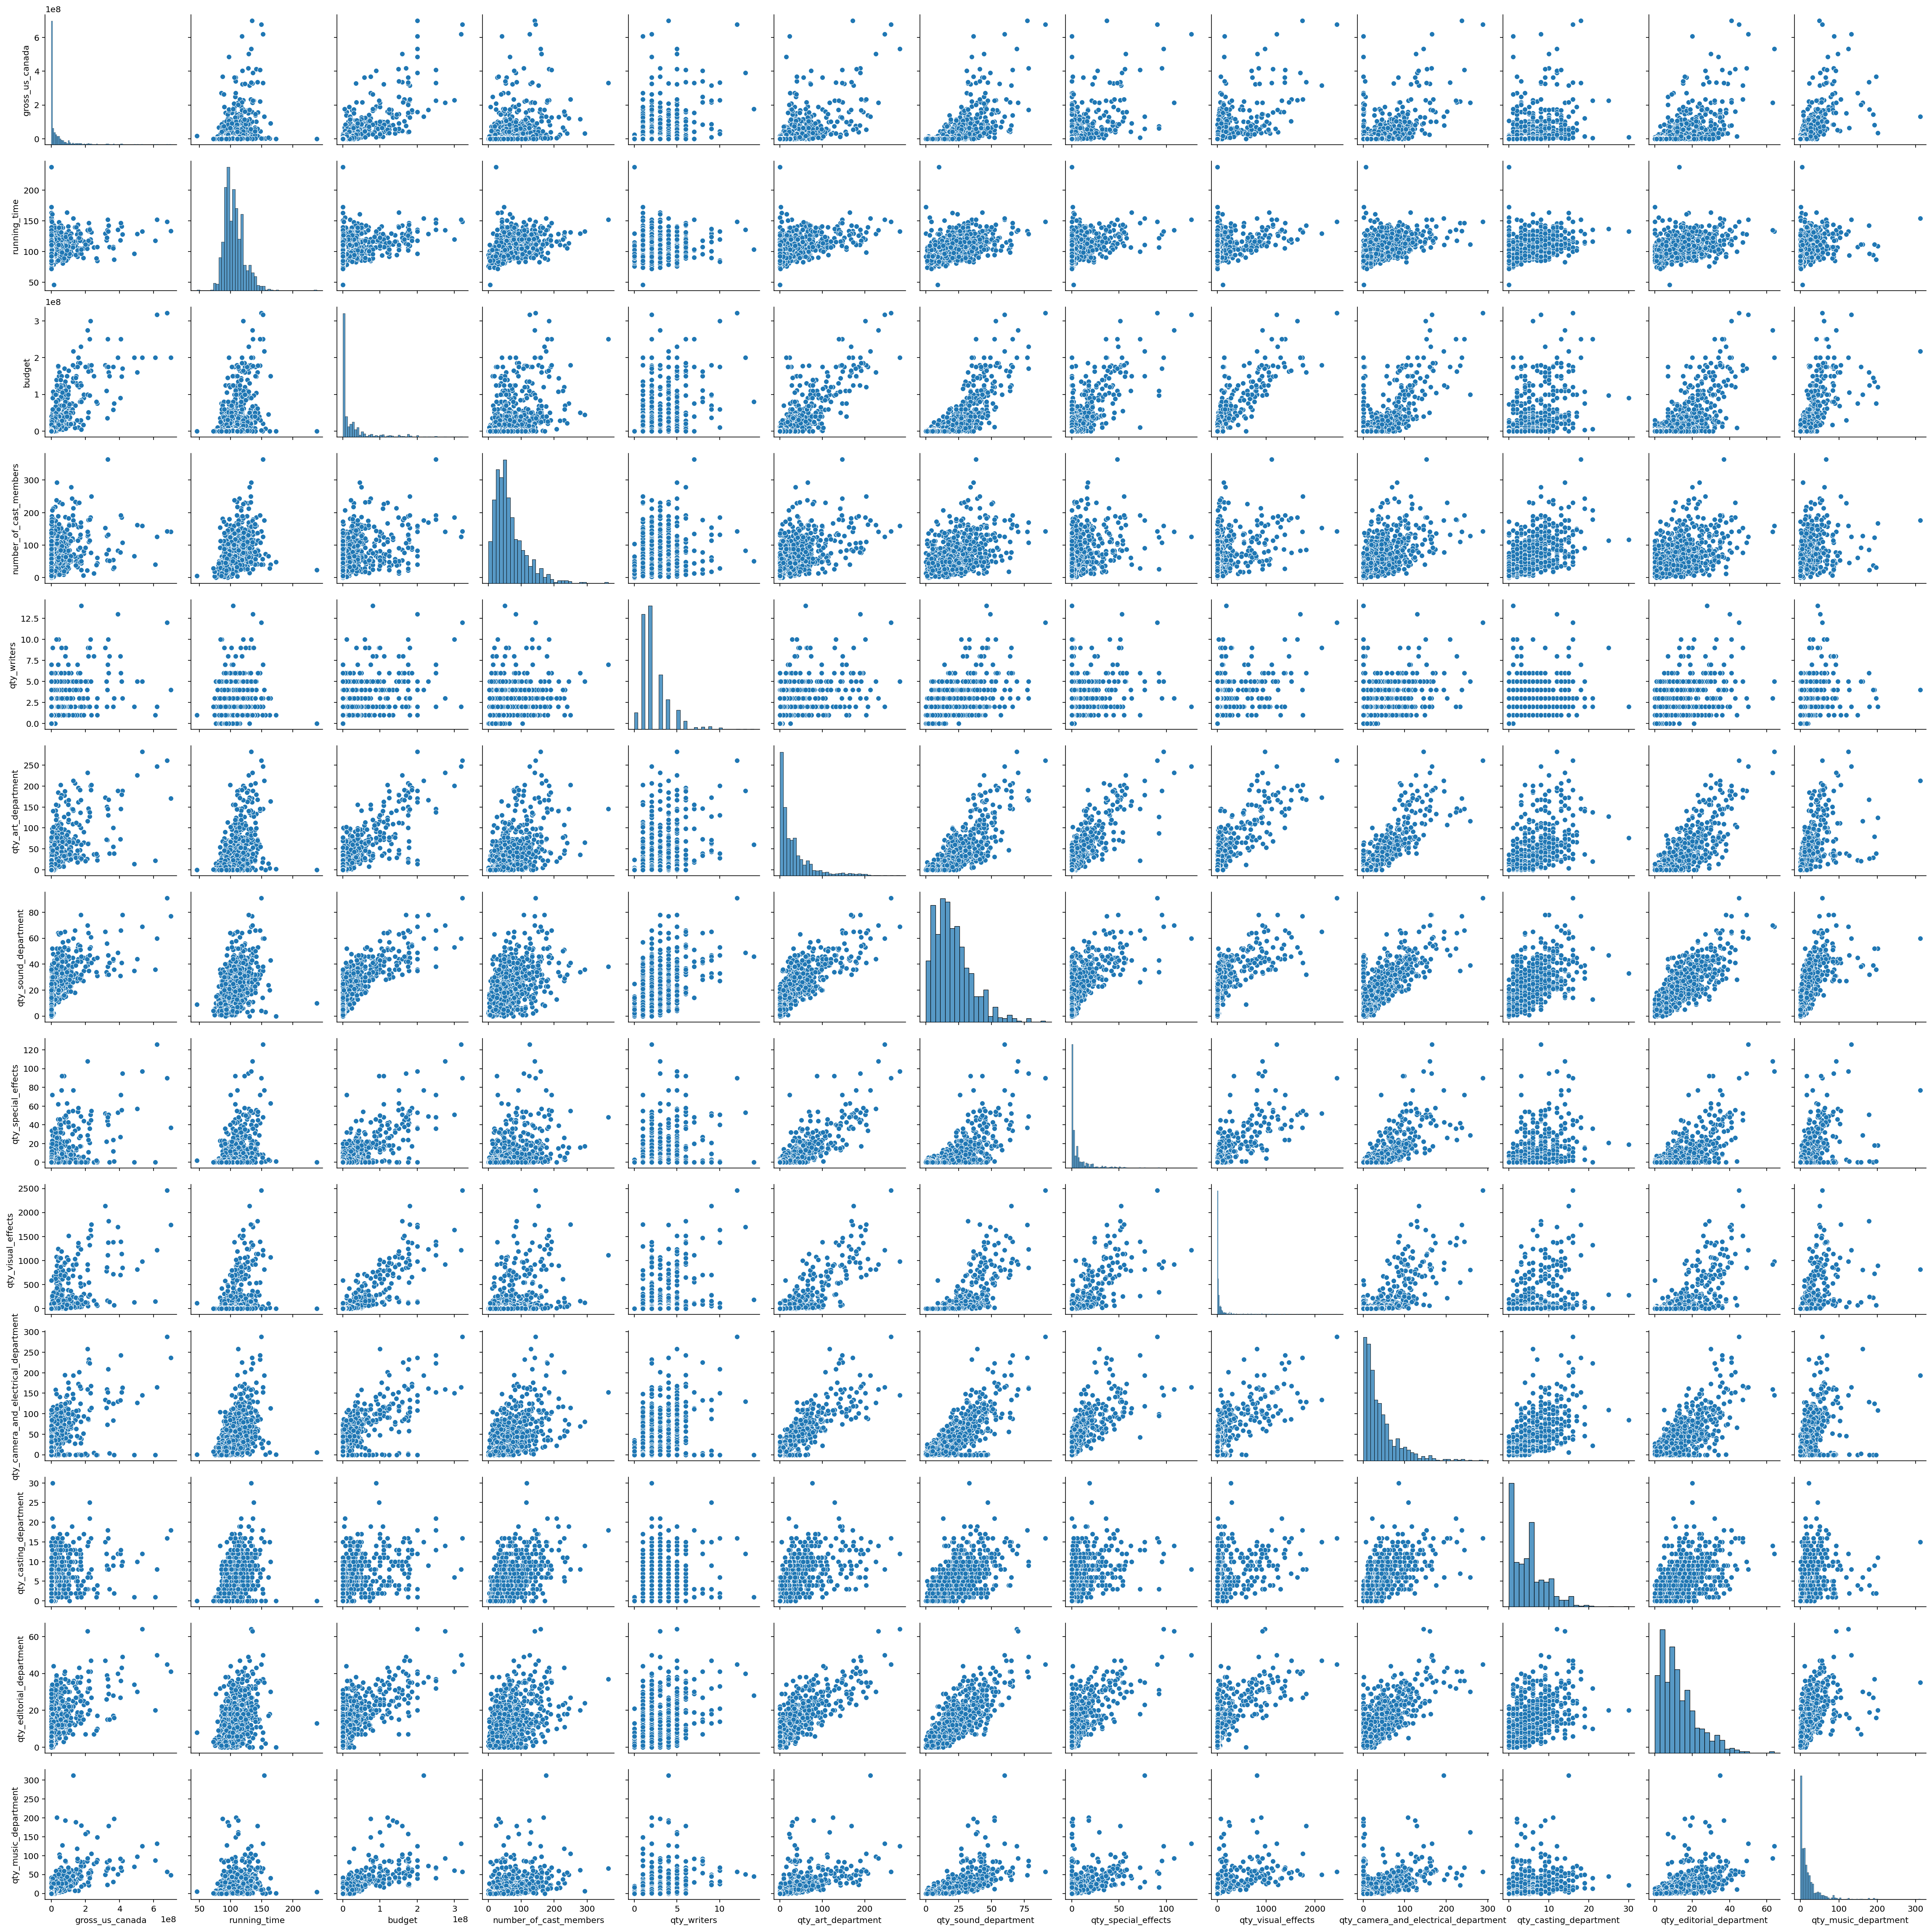

In [9]:
sns.pairplot(df_movies)

#### Initial Takeaways

##### What do the plots tell me about the distribution of the target?

The target is skewed. A transformation may be needed. In general, it is important that the target is approximately normal to meet the assumptions of regression analysis. 

##### Are there any colinearities in the features?

The following may be problematic colinearities between features:

Budget with: 
- qty_art_department
- qty_sound_department
- qty_special_effects
- qty_visual_effects
- qty_camera_and_electrical_department
- qty_editorial_department
- qty_special_effects_companies

Also, these features present colinearity among themselves. Let's see this more clearly in the heatmap bellow:

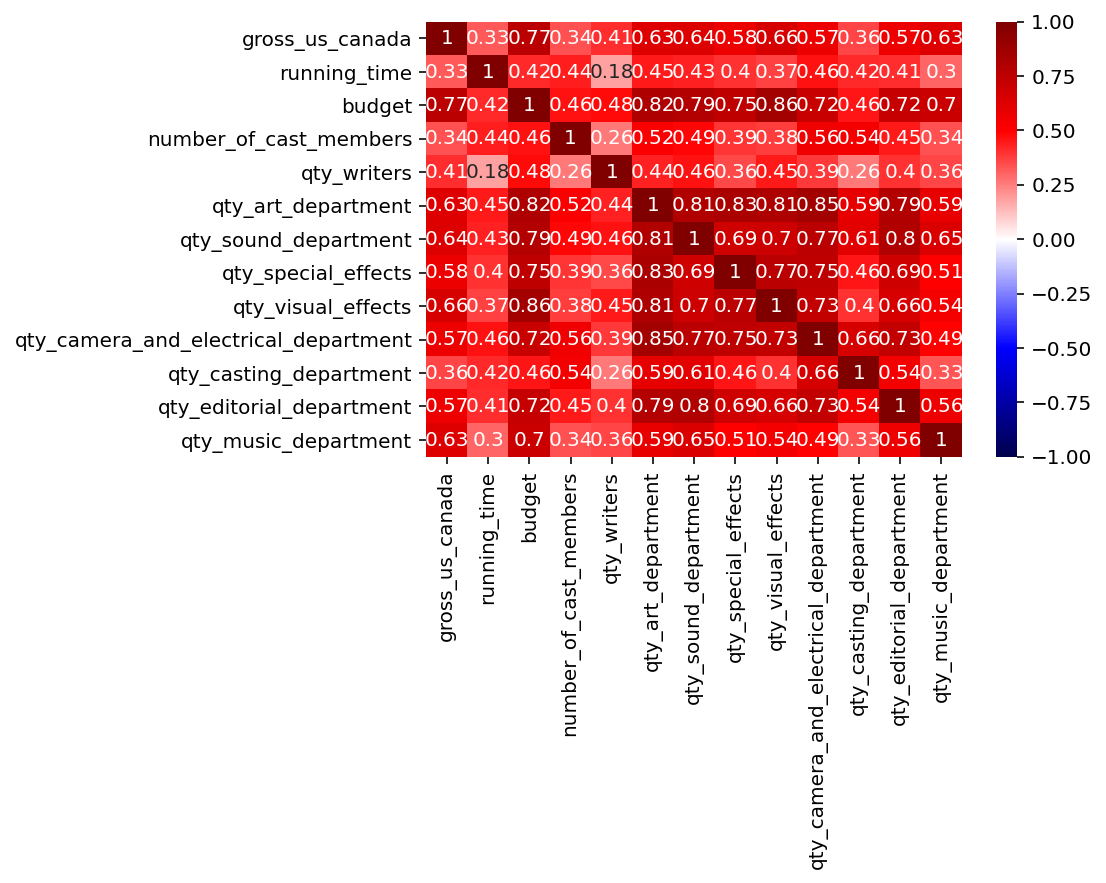

In [10]:
sns.heatmap(df_movies.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

##### What about relationships between each feature and target?

The target is correlated with:
-budget 0.7
-qty_visual_effects 0.66
-qty_sound_department 0.64
-qty_music_department 0.63
-qty_art_department 0.62
-qty_special_effects 0.58
-qty_editorial_department 0.57
-qty_camera_and_electrical_department 0.57
-qty_writers 0.41
-qty_casting_department 0.36
-number_of_cast_members 0.34
-running_time 0.33

It is good that we have 12 features correlated with the target variable. The problem is that 8 of those features present colinearity among them. 

#### Baseline Model

statsmodels gives us an initial look at p-values with this feature set.

In [28]:
X = df_movies[['running_time', 'budget', 'number_of_cast_members',
               'qty_writers', 'qty_art_department', 'qty_sound_department',
               'qty_special_effects', 'qty_visual_effects',
               'qty_camera_and_electrical_department', 'qty_casting_department',
               'qty_editorial_department', 'qty_music_department']]
y = df_movies[['gross_us_canada']]

In [29]:
baseline_model = sm.OLS(y,X)
baseline_fit = baseline_model.fit()
baseline_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        gross_us_canada   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.678
Method:                 Least Squares   F-statistic:                              153.3
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                   6.83e-204
Time:                        21:29:57   Log-Likelihood:                         -16677.
No. Observations:                 870   AIC:                                  3.338e+04
Df Residuals:                     858   BIC:                                  3.344e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
running_time                         -5.591e+04    4.3e+04     -1.300      0.194    -1.4e+05    2.85e+04
budget                                   1.0406      0.091     11.448      0.000       0.862       1.219
number_of_cast_members               -6.206e+04   4.82e+04     -1.287      0.198   -1.57e+05    3.26e+04
qty_writers                            2.11e+06   1.13e+06      1.874      0.061   -9.99e+04    4.32e+06
qty_art_department                   -2.361e+05    1.1e+05     -2.146      0.032   -4.52e+05   -2.01e+04
qty_sound_department                  1.156e+05   2.68e+05      0.431      0.667   -4.11e+05    6.42e+05
qty_special_effects                   1.304e+04   2.28e+05      0.057      0.954   -4.35e+05    4.61e+05
qty_visual_effects                    1.068e+04   1.29e+04      0.825      0.410   -1.47e+04    3.61e+04
qty_camera_and_electrical_department  2.028e+05   9.16e+04      2.213      0.027    2.29e+04    3.83e+05
qty_casting_department                2.463e+05   5.88e+05      0.419      0.675   -9.07e+05     1.4e+06
qty_editorial_department              -2.92e+04   3.24e+05     -0.090      0.928   -6.65e+05    6.06e+05
qty_music_department                  5.035e+05   9.16e+04      5.497      0.000    3.24e+05    6.83e+05
==============================================================================
Omnibus:                      538.900   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11668.486
Skew:                           2.410   Prob(JB):                         0.00
Kurtosis:                      20.282   Cond. No.                     3.64e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.64e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Build the same model with sklearn and then score an initial train/test.

In [30]:
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 10)
print(X.shape, X_test.shape, y.shape, y_test.shape)

(696, 12) (174, 12) (696, 1) (174, 1)


In [31]:
#further partitioning X and y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(522, 12) (174, 12) (522, 1) (174, 1)


In [32]:
#set up the 2 models we're choosing from:

lm = LinearRegression()

#Feature scale for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

lm_reg = Ridge(alpha = 1)


(522, 12) (174, 12) (174, 12)


In [33]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

Linear Regression val R^2: 0.534
Ridge Regression val R^2: 0.534


The initial R2 score is 0.534 for both Linear Regression and Ridge. As a final attempt, let's create some polynomial terms. 

In [35]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree = 2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)
print(X_train_poly.shape, X_val_poly.shape, X_test_poly.shape)

lm_poly = LinearRegression()

(522, 91) (174, 91) (174, 91)


In [36]:
#validate

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Degree 2 polynomial regression R^2: -0.187


The negative R2 indicates some overfitting with the polynomial features. Let's test out the results using a LASSO model.

In [39]:
# Lasso
alphas_ =  (np.arange(0.005,1.0, 0.05)).tolist() + [1] 

for c in alphas_:
        print ('For alpha: ', c )
        lasso = Lasso(alpha=c, max_iter=200000)
        lasso.fit(X_train, y_train)
        print ('Train score: ', lasso.score(X_train, y_train))
        print ('Val score: ', lasso.score(X_val, y_val))

For alpha:  0.005
Train score:  0.6467286588107073
Val score:  0.5338102011312753
For alpha:  0.055
Train score:  0.6467286588107073
Val score:  0.5338102011697067
For alpha:  0.10500000000000001
Train score:  0.6467286588107072
Val score:  0.5338102012081369
For alpha:  0.15500000000000003
Train score:  0.6467286588107073
Val score:  0.5338102012465678
For alpha:  0.20500000000000002
Train score:  0.6467286588107073
Val score:  0.5338102012850032
For alpha:  0.255
Train score:  0.6467286588107073
Val score:  0.5338102013234294
For alpha:  0.30500000000000005
Train score:  0.6467286588107073
Val score:  0.5338102013618602
For alpha:  0.35500000000000004
Train score:  0.6467286588107073
Val score:  0.5338102014002909
For alpha:  0.405
Train score:  0.6467286588107073
Val score:  0.5338102014387264
For alpha:  0.455
Train score:  0.6467286588107073
Val score:  0.5338102014771572
For alpha:  0.505
Train score:  0.6467286588107073
Val score:  0.533810201515588
For alpha:  0.555
Train score

In [61]:
#running Lasso, Alpha = 1
names = list(X.columns)

df = pd.DataFrame()
      
df['Feature Name'] = names

lasso = Lasso(alpha=1, max_iter=20000)
lasso.fit(X_train, y_train)
        
        # Create a column name for that alpha value
column_name = 'Alpha = 1'

        # Create a column of coefficient values
df[column_name] = lasso.coef_
        
    # Return the datafram    
print(df)

                            Feature Name     Alpha = 1
0                           running_time  2.597933e+04
1                                 budget  1.161343e+00
2                 number_of_cast_members -1.600514e+05
3                            qty_writers  1.879591e+06
4                     qty_art_department -2.348759e+05
5                   qty_sound_department  3.424119e+05
6                    qty_special_effects  5.075464e+05
7                     qty_visual_effects -6.270397e+03
8   qty_camera_and_electrical_department  2.027335e+05
9                 qty_casting_department  6.209354e+05
10              qty_editorial_department -1.211939e+05
11                  qty_music_department  2.918775e+05


In [43]:
#Validating Lasso with Alpha = 1
lasso = Lasso(alpha=1, max_iter=200000)
lasso.fit(X_train, y_train)
print ('Train score: ', lasso.score(X_train_poly, y_train))
print ('Val score: ', lasso.score(X_val_poly, y_val))

Train score:  0.6467286588107072
Val score:  0.5338102018960531


#### Decision to Pivot Project

After creating a baseline model, adding polynomial features and running a LASSO, here are my options:
    - spend more time on feature engineering, using more elaborate features
    - Find different seatures
Nevertheless, at this time, I have two weeks to complete the project.

#### Final Model

Eliminating the variables that are presenting colinearity. 

In [77]:
df_movies_subset = df_movies[['running_time', 'budget', 'number_of_cast_members', 'qty_writers', 'gross_us_canada']].copy()

In [78]:
Xr, yr = df_movies_subset.drop('gross_us_canada',axis=1), df_movies_subset['gross_us_canada']
print(X.shape, y.shape)

(696, 4) (696,)


In [79]:
# hold out 20% of the data for final testing
Xr, Xr_test, yr, yr_test = train_test_split(X, y, test_size=.2, random_state=10)
print(X.shape, X_test.shape, y.shape, y_test.shape)

(696, 4) (174, 4) (696,) (174,)


In [80]:
#further partitioning X and y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
Xr_train, Xr_val, yr_train, yr_val = train_test_split(X, y, test_size=.25, random_state=3)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(522, 12) (174, 12) (522, 1) (174, 1)


In [81]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

Xr_train_scaled = scaler.fit_transform(Xr_train.values)
Xr_val_scaled = scaler.transform(Xr_val.values)
Xr_test_scaled = scaler.transform(Xr_test.values)
print(Xr_train_scaled.shape, Xr_val_scaled.shape, Xr_test_scaled.shape)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

Xr_train_poly = poly.fit_transform(Xr_train.values)
Xr_val_poly = poly.transform(Xr_val.values)
Xr_test_poly = poly.transform(Xr_test.values)
print(Xr_train_poly.shape, Xr_val_poly.shape, Xr_test_poly.shape)

lm_poly = LinearRegression()

(522, 4) (174, 4) (140, 4)
(522, 15) (174, 15) (140, 15)


In [98]:
#validate

lm.fit(Xr_train, yr_train)
print(f'Linear Regression val R^2: {lm.score(Xr_val, yr_val):.3f}')

lm_reg.fit(Xr_train_scaled, yr_train)
print(f'Ridge Regression val R^2: {lm_reg.score(Xr_val_scaled, yr_val):.3f}')

lm_poly.fit(Xr_train_poly, yr_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(Xr_val_poly, yr_val):.3f}')

Linear Regression val R^2: 0.357
Ridge Regression val R^2: 0.358
Degree 2 polynomial regression val R^2: 0.375


### Final Test

In [96]:
lm.fit(Xr, yr)
print(f'Final R2 Score: {lm.score(Xr_test, yr_test)}')

rmse = math.sqrt(mean_squared_error(yr_test, lm.predict(Xr_test)))
print(f'Final RMSE Score: {rmse}')

mse = ((lm.predict(Xr) - yr)**2).mean()
print(f'Final MSE Score: {mse}')

Final R2 Score: 0.5110399474884469
Final RMSE Score: 46090580.93901365
Final MSE Score: 3038939504198033.5


In [101]:
lm.coef_

array([ 7.25721228e+04,  1.42400141e+00, -9.22312671e+04,  2.68252857e+06])